<a href="https://colab.research.google.com/github/callacius/ReconhecimentoFacial_dio/blob/main/Reconhecimento_facial_dio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projeto Final: EY Fast Track Specialist - Machine Learning ##

<img src="https://hermes.digitalinnovation.one/tracks/de18ed26-6526-4793-bb3f-b00afc766889.png" width="200" />

Este projeto foi desenvolvido para aceleração “EY Fast Track Specialist – Machine Learning” promovido pela [DIO](https://www.dio.me/).

O Projeto consiste em usar ferramentas de machine learning para treinar um modelo que identifique o presidente americano Ronald Reagan e sua esposa Nancy Davis, para treino e teste foi usado a ferramenta do google colab que é um produto do Google Research, área de pesquisas científicas do Google. O Colab permite que qualquer pessoa escreva e execute código Python arbitrário pelo navegador e é especialmente adequado para aprendizado de máquina, análise de dados e educação.

Foi usado principalmente as seguintes bibliotecas: 

- **OpenCV** Biblioteca de software de visão computacional e aprendizado de máquina de código aberto. O OpenCV foi construído para fornecer uma infraestrutura comum para aplicações de visão computacional e para acelerar o uso da percepção da máquina nos produtos comerciais.
- **dlib** Biblioteca multiplataforma escrita na linguagem de programação C++. Contém componentes de software para lidar com redes, threads, interfaces gráficas de usuário, estruturas de dados, álgebra linear, machine learning, processamento de imagens, mineração de dados, análise de XML e texto, otimização numérica, redes bayesianas, e muitas outras tarefas. 

Carregar bibliotecas necessárias para execução do projeto 

In [2]:
import os
import glob
import _pickle as cPickle
import dlib
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [13]:
!wget -N 'https://github.com/fenollp/data.shape_predictor_68_face_landmarks/raw/main/shape_predictor_68_face_landmarks.dat'
!wget -N 'http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2'
!wget -N 'https://github.com/callacius/ReconhecimentoFacial_dio/raw/main/imagens/imagens.zip'
!bzip2 -dk dlib_face_recognition_resnet_model_v1.dat.bz2
!unzip -q imagens.zip

--2022-10-26 03:08:06--  https://github.com/fenollp/data.shape_predictor_68_face_landmarks/raw/main/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fenollp/data.shape_predictor_68_face_landmarks/main/shape_predictor_68_face_landmarks.dat [following]
--2022-10-26 03:08:06--  https://raw.githubusercontent.com/fenollp/data.shape_predictor_68_face_landmarks/main/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_

In [14]:
detectorFace = dlib.get_frontal_face_detector()
detectorPontos = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
reconhecimentoFacial = dlib.face_recognition_model_v1("/content/dlib_face_recognition_resnet_model_v1.dat")

indice = {}
idx = 0
descritoresFaciais = None

for arquivo in glob.glob(os.path.join("/content/imagens/treinamento", "*.jpg")):
  imagem = cv2.imread(arquivo)
  facesDetectadas = detectorFace(imagem, 1)
  numeroFacesDetectadas = len(facesDetectadas)
  if numeroFacesDetectadas > 1:
    print("Há mais de uma face na imagem {}".format(arquivo))
    exit(0)
  elif numeroFacesDetectadas < 1:
    print("Nenhuma face encontrada no arquivo {}".format(arquivo))
    exit(0)
  for face in facesDetectadas:
    pontosFaciais = detectorPontos(imagem, face)
    descritorFacial = reconhecimentoFacial.compute_face_descriptor(imagem, pontosFaciais)
    listaDescritorFacial = [df for df in descritorFacial]
    npArrayDescritorFacial = np.asarray(listaDescritorFacial, dtype=np.float64)
    npArrayDescritorFacial = npArrayDescritorFacial[np.newaxis, :]
    if descritoresFaciais is None:
      descritoresFaciais = npArrayDescritorFacial
    else:
      descritoresFaciais = np.concatenate((descritoresFaciais, npArrayDescritorFacial), axis=0)
    indice[idx] = arquivo
    idx += 1

np.save("/content/descritores_rn.npy", descritoresFaciais)
with open("/content/indices_rn.pickle", 'wb') as f:
  cPickle.dump(indice, f)

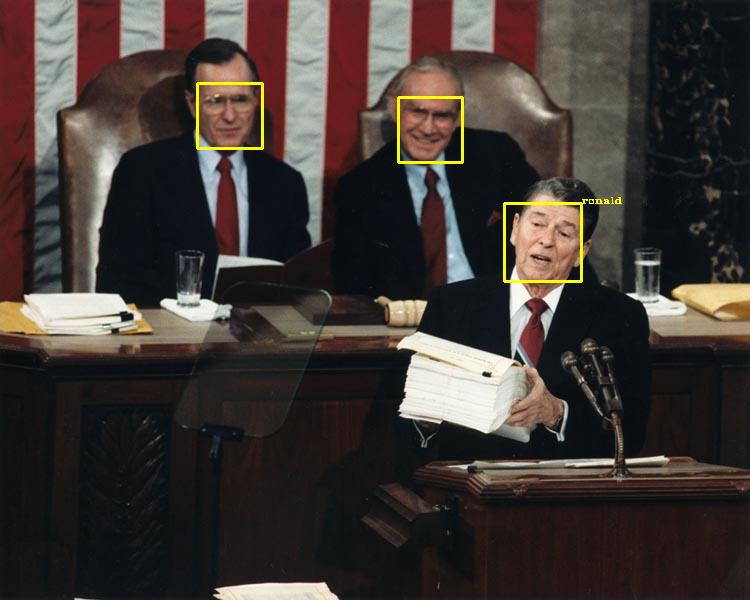

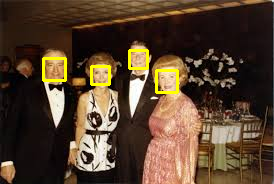

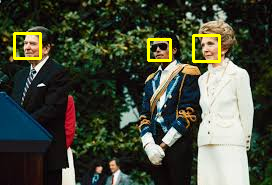

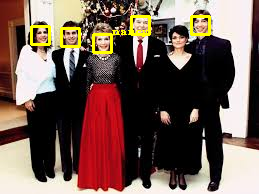

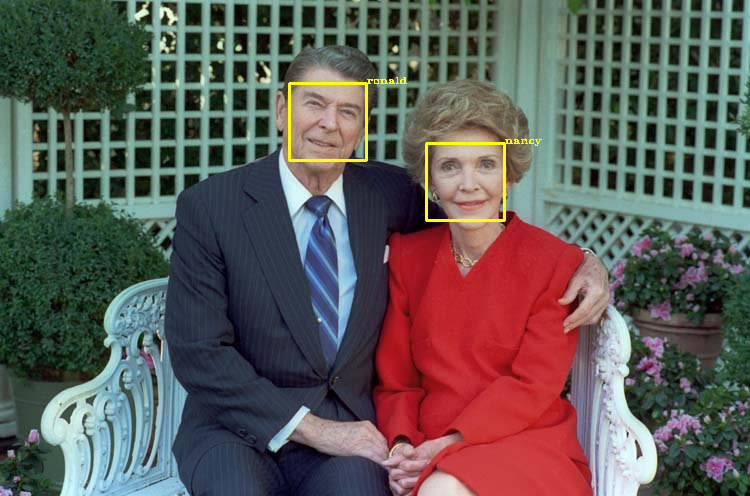

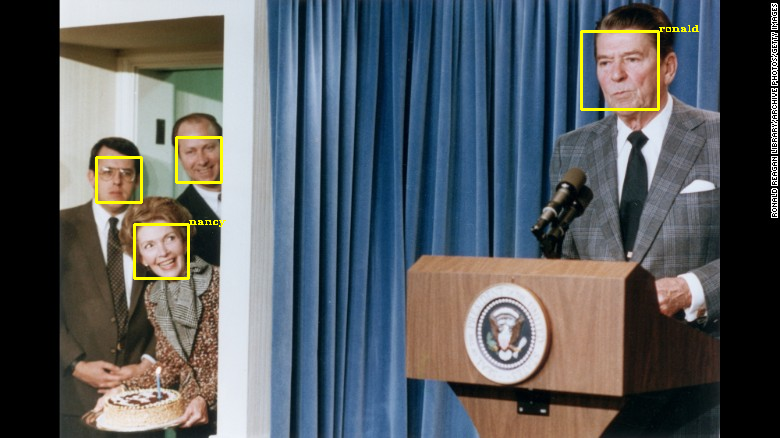

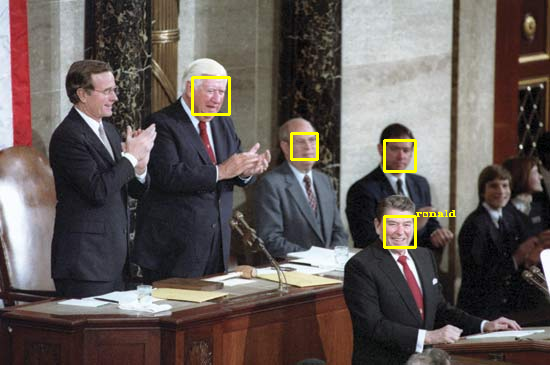

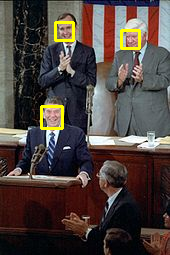

In [15]:
detectorFace = dlib.get_frontal_face_detector()
detectorPontos = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
reconhecimentoFacial = dlib.face_recognition_model_v1("/content/dlib_face_recognition_resnet_model_v1.dat")
indices = np.load("/content/indices_rn.pickle",allow_pickle=True)
descritoresFaciais = np.load("/content/descritores_rn.npy",allow_pickle=True)
limiar = 0.5

for arquivo in glob.glob(os.path.join("imagens", "*.jpg")):
  imagem = cv2.imread(arquivo)
  facesDetectadas = detectorFace(imagem, 2)
  for face in facesDetectadas:
    e, t, d, b = (int(face.left()), int(face.top()), int(face.right()), int(face.bottom()))
    pontosFaciais = detectorPontos(imagem, face)
    descritorFacial = reconhecimentoFacial.compute_face_descriptor(imagem, pontosFaciais)
    listaDescritorFacial = [fd for fd in descritorFacial]
    npArrayDescritorFacial = np.asarray(listaDescritorFacial, dtype=np.float64)
    npArrayDescritorFacial = npArrayDescritorFacial[np.newaxis, :]
    distancias = np.linalg.norm(npArrayDescritorFacial - descritoresFaciais, axis=1)
    minimo = np.argmin(distancias)
    distanciaMinima = distancias[minimo]
    if distanciaMinima <= limiar:
      nome = os.path.split(indices[minimo])[1].split(".")[0]
    else:
      nome = ' '
    cv2.rectangle(imagem, (e, t), (d, b), (0, 255, 255), 2)
    texto = "{}".format(nome)
    cv2.putText(imagem, texto, (d, t), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (0, 255, 255))
  cv2_imshow(imagem)
  cv2.waitKey(0)
cv2.destroyAllWindows()